## Parte 2

Uma rede de email trocados pelos funcionários de uma dada empresa será o objeto de estudo das próximas duas questões. Cada nó corresponde a um funcionário da empresa e cada aresta indica que pelo menos um email foi enviado entre duas pessoas.

A rede também contém atributos nos nós, são eles: 'Department' e 'ManagementSalary'.

O atributo 'Department' indica em qual departamento da empresa o funcionário trabalha. O atributo 'ManagementSalary' (Salário de Gerente) indica se essa pessoa está recebendo um salário de cargo de gerência.

O arquivo 'email_gpickle.txt' carrega a rede de emails trocados pelos funcionários da empresa.

### Questão 2

Objetivo: Prever quais pessoas poderão vir a receber um salário de gerente-

Para fazer isso, primeiro você deverá dividir os dados de treinamento e teste, depois será preciso criar uma matriz de características do nó, e em seguida treinar um classificador para prever a probabilidade do nó receber um salário de gerenciamento, por fim prever com os dados de teste.

A métrica de avaliação para esta questão é AUC.

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import os
import tempfile
import sklearn
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [3]:
# Lendo a rede:

G = nx.read_gpickle("email.gpickle")

print(nx.info(G))

G.nodes(data=True)

Name: 
Type: Graph
Number of nodes: 753
Number of edges: 9746
Average degree:  25.8858


NodeDataView({'0': {'Department': 1, 'ManagementSalary': 0.0}, '17': {'Department': 1, 'ManagementSalary': 0.0}, '146': {'Department': 15, 'ManagementSalary': 0.0}, '581': {'Department': 3, 'ManagementSalary': 0.0}, '268': {'Department': 39, 'ManagementSalary': 0.0}, '221': {'Department': 1, 'ManagementSalary': 0.0}, '218': {'Department': 1, 'ManagementSalary': 0.0}, '734': {'Department': 1, 'ManagementSalary': 0.0}, '178': {'Department': 0, 'ManagementSalary': 0.0}, '459': {'Department': 1, 'ManagementSalary': 0.0}, '250': {'Department': 7, 'ManagementSalary': 0.0}, '148': {'Department': 0, 'ManagementSalary': 0.0}, '73': {'Department': 1, 'ManagementSalary': 0.0}, '74': {'Department': 1, 'ManagementSalary': 0.0}, '248': {'Department': 1, 'ManagementSalary': 0.0}, '498': {'Department': 14, 'ManagementSalary': 1.0}, '226': {'Department': 1, 'ManagementSalary': 0.0}, '377': {'Department': 7, 'ManagementSalary': 1.0}, '177': {'Department': 1, 'ManagementSalary': 0.0}, '560': {'Department

In [4]:
# Transformando em um dataframe:

data = np.array(G.nodes(data=True))
df = pd.DataFrame({'ManagementSalary': [d['ManagementSalary'] for d in data[:, 1]],\
                   'department': [d['Department'] for d in data[:, 1]]},\
                  index=data[:, 0])

In [5]:
df.head()

,ManagementSalary,department
0,0.0,1
17,0.0,1
146,0.0,15
581,0.0,3
268,0.0,39


In [6]:
# Adicionando algumas informações:

df['clustering'] = pd.Series(nx.clustering(G))
df['degree_centrality'] = pd.Series(nx.degree_centrality(G))
df['betweeness'] = pd.Series(nx.betweenness_centrality(G, normalized=True))
df['pr'] = pd.Series(nx.pagerank(G))

In [7]:
# Por algum motivo o parâmetro para normalizar está dando erro:

#nx.closeness_centrality(G, normalized=True)

In [8]:
# Então, vamos fazer a normalização manualmente:

close_cent= nx.closeness_centrality(G)
norm = 0
lista_close_cen = []
for keys in close_cent.keys():
    norm = norm + (close_cent[keys])**2
norm = np.sqrt(norm)
for keys in close_cent.keys():
    close_cent[keys] = close_cent[keys]/norm
    lista_close_cen.append(close_cent[keys])

In [9]:
# Adicionando ao dataframe:

df['closeness_centrality'] = lista_close_cen 

In [10]:
# Adicionando o grau ao dataframe:

a=list(G.degree())
lista_degree=[]
for i in range(0,len(a)):
    lista_degree.append(a[i][1])
df['degree'] = lista_degree

In [11]:
neg, pos = np.bincount(df['ManagementSalary'])
total = neg + pos
print('Total: {}\n    Positivos: {} ({:.2f}% do total)\n'.format(
    total, pos, 100 * pos / total))

Total: 753
    Positivos: 119 (15.80% do total)



Claramente, dataframe desbalanceado.

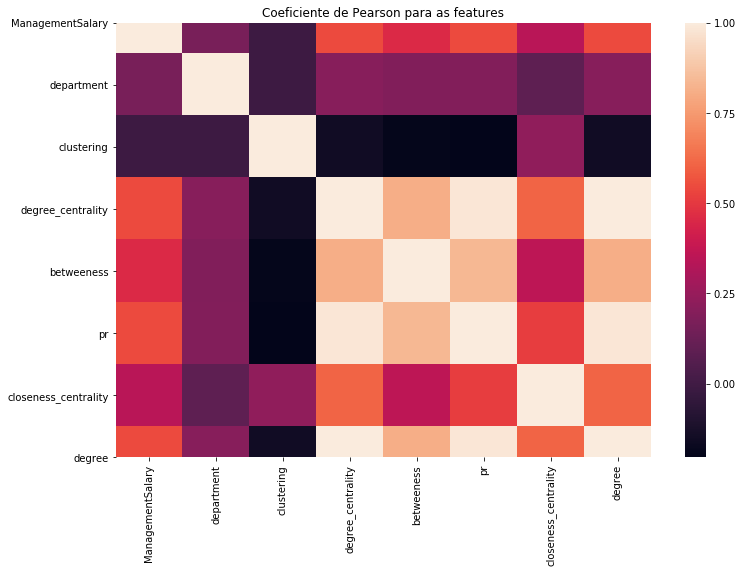

In [12]:
# Matriz de correlação

plt.figure(figsize=[12,8])
plt.title('Coeficiente de Pearson para as features')
sns.heatmap(df.corr())
plt.show()

In [13]:
# Separando os dataframes:

cols1 = ['department', 'clustering', 'degree_centrality',
       'betweeness', 'pr', 'closeness_centrality', 'degree']
cols2 = ['ManagementSalary']
X = df[cols1]
y = df[cols2]

In [14]:
# Colocando os números em escala:

sc = StandardScaler()
X = sc.fit_transform(X)
y=np.array(y)

In [15]:
# Alguns algoritmos:

MLA = [
   ensemble.AdaBoostClassifier(n_estimators=5),
   ensemble.BaggingClassifier(n_estimators=5),
   ensemble.ExtraTreesClassifier(n_estimators=5,max_depth=2),
   ensemble.GradientBoostingClassifier(n_estimators=5,max_depth=2),
   ensemble.RandomForestClassifier(n_estimators=5, max_depth=2),

   gaussian_process.GaussianProcessClassifier(),
    
   linear_model.LogisticRegressionCV(),
   linear_model.PassiveAggressiveClassifier(),
   linear_model.RidgeClassifierCV(),
   linear_model.SGDClassifier(),
   linear_model.Perceptron(),
    
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(probability=True),
    svm.LinearSVC(),
      
   tree.DecisionTreeClassifier(),
   tree.ExtraTreeClassifier(),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

   XGBClassifier()    
    ]

# Dividindo o dataset:

cv_split = ShuffleSplit(n_splits = 5, test_size = .3, train_size = .7, random_state = 42)

# Criando um dataframe para ver os resultados:

MLA_columns = ['Name', 'Parameters','Train AUC Mean', 'Test AUC Mean', 'Train Accuracy Mean', 'Test Accuracy Mean' , 
               'Train Precision Mean', 'Test Precision Mean', 'Train Recall Mean', 'Test Recall Mean', 
               'Train F1-Score Mean', 'Test F1-Score Mean' ,'Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in MLA:

    # Dados do dataframe:
    
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'Name'] = MLA_name
    MLA_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    # Score com cross-validation:
    
    cv_results = cross_validate(alg, X, y, cv  = cv_split, return_train_score=True, n_jobs=-1, 
                                scoring = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])
        
    MLA_compare.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'Train AUC Mean'] = cv_results['train_roc_auc'].mean()
    MLA_compare.loc[row_index, 'Test AUC Mean'] = cv_results['test_roc_auc'].mean()
    MLA_compare.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_accuracy'].mean()
    MLA_compare.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_accuracy'].mean()   
    MLA_compare.loc[row_index, 'Train Precision Mean'] = cv_results['train_precision'].mean()
    MLA_compare.loc[row_index, 'Test Precision Mean'] = cv_results['test_precision'].mean()   
    MLA_compare.loc[row_index, 'Train Recall Mean'] = cv_results['train_recall'].mean()
    MLA_compare.loc[row_index, 'Test Recall Mean'] = cv_results['test_recall'].mean()   
    MLA_compare.loc[row_index, 'Train F1-Score Mean'] = cv_results['train_f1'].mean()
    MLA_compare.loc[row_index, 'Test F1-Score Mean'] = cv_results['test_f1'].mean()   
    row_index+=1

MLA_compare.sort_values(by = ['Test AUC Mean'], ascending = False, inplace = True)
MLA_compare

,Name,Parameters,Train AUC Mean,Test AUC Mean,Train Accuracy Mean,Test Accuracy Mean,Train Precision Mean,Test Precision Mean,Train Recall Mean,Test Recall Mean,Train F1-Score Mean,Test F1-Score Mean,Time
20,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.997817,0.942246,0.979886,0.90531,0.981468,0.768892,0.887646,0.620486,0.932022,0.683073,0.626041
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.937845,0.925209,0.890702,0.89292,0.888075,0.927371,0.334982,0.383977,0.485967,0.536575,0.0175524
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.941114,0.924155,0.905123,0.899115,0.894136,0.888537,0.438163,0.447386,0.587926,0.589248,0.218988
15,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.924756,0.923574,0.8926,0.90531,0.795162,0.885091,0.411349,0.497601,0.541615,0.631839,0.0105717
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.919484,0.916074,0.894877,0.897345,0.804493,0.840216,0.423495,0.480162,0.55428,0.603242,0.0771941
9,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.908961,0.904883,0.858065,0.858407,0.625682,0.634738,0.536805,0.580061,0.515221,0.564824,0.0021945
7,PassiveAggressiveClassifier,"{'C': 1.0, 'average': False, 'class_weight': N...",0.899464,0.89515,0.871347,0.858407,0.601781,0.623864,0.542836,0.540344,0.539956,0.530947,0.00119686
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.936476,0.894859,0.913852,0.89646,0.892203,0.830504,0.519102,0.510723,0.648108,0.620781,0.00718122
19,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.88716,0.89302,0.826186,0.824779,0.463,0.499322,0.617636,0.603248,0.52518,0.533892,0.0027925
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.998036,0.886845,0.98482,0.89823,0.965038,0.704155,0.936172,0.6857,0.950175,0.690637,0.00937424


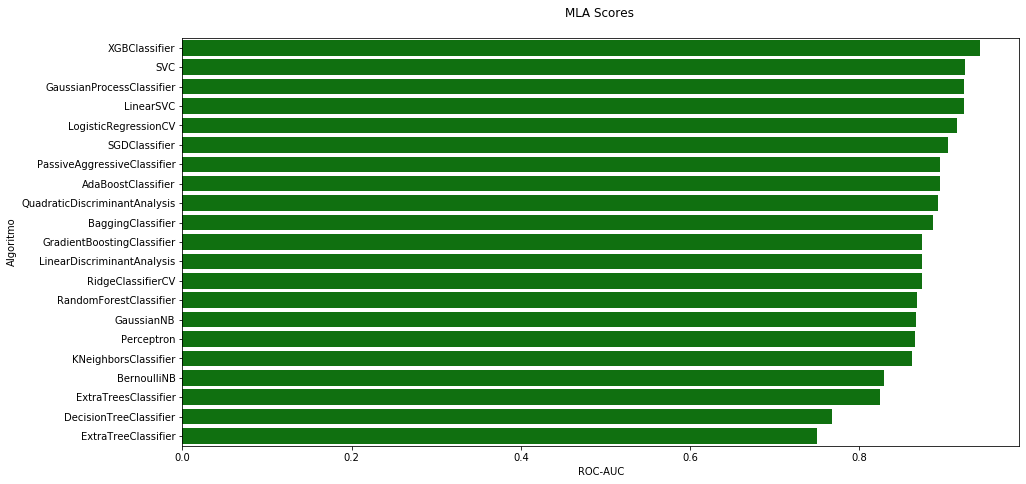

In [16]:
plt.figure(figsize=[15,7.5])
sns.barplot(x='Test AUC Mean', y = 'Name', data = MLA_compare, color = 'g')
plt.title('MLA Scores \n')
plt.xlabel('ROC-AUC')
plt.ylabel('Algoritmo')
plt.show()

Alguns algoritmos (principalmente aqueles baseados em árvores de decisão) estão fazendo overfitting. Os algoritmos SVC, LinearSVC e LogisticRegressionCV são aqueles que obtiveram melhor desempenho na métrica AUC sem fazer uso de overfitting.